## DC2 Classification Accuracy

In [1]:
import torch
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import sklearn.metrics

from hydra import initialize, compose
from hydra.utils import instantiate

from case_studies.dc2_cataloging.utils.load_full_cat import get_full_cat
from case_studies.dc2_cataloging.utils.notebook_variables import NoteBookVariables

output_dir = Path("./classification_accuracy_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp_07/exp_07-11-1/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
test_image_idx = 0
test_image, test_image_cat, bliss_full_cat, lsst_full_cat = get_full_cat(notebook_cfg, 
                                                             test_image_idx, 
                                                             model_path, 
                                                             lsst_root_dir, 
                                                             device)
image_lim = test_image.shape[1]
test_image = test_image[2]  # r-band

In [4]:
matcher = instantiate(notebook_cfg.encoder.matcher)
bliss_metrics = instantiate(notebook_cfg.encoder.mode_metrics)
bliss_metrics = bliss_metrics["source_type_accuracy"]
lsst_metrics = bliss_metrics.clone()

flux_bin_cutoffs = bliss_metrics.flux_bin_cutoffs

bliss_matching = list(matcher.match_catalogs(test_image_cat, bliss_full_cat)[0])
lsst_matching = list(matcher.match_catalogs(test_image_cat, lsst_full_cat)[0])

bliss_metrics.update(test_image_cat, bliss_full_cat, [bliss_matching])
lsst_metrics.update(test_image_cat, lsst_full_cat, [lsst_matching])

bliss_internal_states = bliss_metrics.get_internal_states()
lsst_internal_states = lsst_metrics.get_internal_states()

In [5]:
plt.rcParams.update({"font.size": NoteBookVariables.font_size})

def plot(bliss_internal_states,
         lsst_internal_states,
         flux_bin_cutoffs):
    xlabels = (
        ["[100, " + str(flux_bin_cutoffs[0]) + "]"]
        + [f"[{flux_bin_cutoffs[i]}, {flux_bin_cutoffs[i + 1]}]" for i in range(len(flux_bin_cutoffs) - 1)]
        + ["> " + str(flux_bin_cutoffs[-1])]
    )

    bar_plot_data = {
        "BLISS Star TP": bliss_internal_states["star_tp"],
        "# Star": bliss_internal_states["n_matches"] - bliss_internal_states["gal_tp"] - bliss_internal_states["star_fp"],
        "BLISS Galaxy TP": bliss_internal_states["gal_tp"],
        "# Galaxy": bliss_internal_states["n_matches"] - bliss_internal_states["star_tp"] - bliss_internal_states["gal_fp"],
    }

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(
        1, 1, figsize=NoteBookVariables.figsize, layout="constrained"
    )
    color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    x = np.arange(len(xlabels)) * 45
    width = 10
    multiplier = 0

    for i, (data_name, data) in enumerate(bar_plot_data.items()):
        offset = width * multiplier
        rects = ax.bar(x + offset, data, width, color=color_list[i], label=data_name)
        ax.bar_label(rects, padding=3, fontsize=6)
        multiplier += 1

    ax.set_ylabel("Count")
    ax.set_xlabel("Flux (nJy)")
    ax.set_xticks(x + width)
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_yscale("log")
    ax.set_ylim(top=1e5)
    ax.grid(visible=False, axis="x")
    ax.legend(loc="upper right")
    
    ax2 = ax.twinx()

    def get_f1(internal_states, galaxy: bool):
        if galaxy:
            recall = internal_states["gal_tp"] / (internal_states["gal_tp"] + internal_states["star_fp"])
            precision = internal_states["gal_tp"] / (internal_states["gal_tp"] + internal_states["gal_fp"])
        else:
            recall = internal_states["star_tp"] / (internal_states["star_tp"] + internal_states["gal_fp"])
            precision = internal_states["star_tp"] / (internal_states["star_tp"] + internal_states["star_fp"])
        f1 = 2 * precision * recall / (precision + recall)
        return f1
    
    bliss_gal_f1,  = ax2.plot(
        x + width,
        get_f1(bliss_internal_states, galaxy=True),
        "-o",
        color=color_list[4],
        label=f"BLISS F1",
    )
    lsst_gal_f1,  = ax2.plot(
        x + width,
        get_f1(lsst_internal_states, galaxy=True),
        "-o",
        color=color_list[5],
        label=f"LSST F1",
    )
    
    ax2.set_ylabel("Classification F1")
    ax2.grid(visible=False, axis="both")
    fig.legend(handles=[bliss_gal_f1, lsst_gal_f1], loc="outside upper center", ncols=2)

    return fig, ax

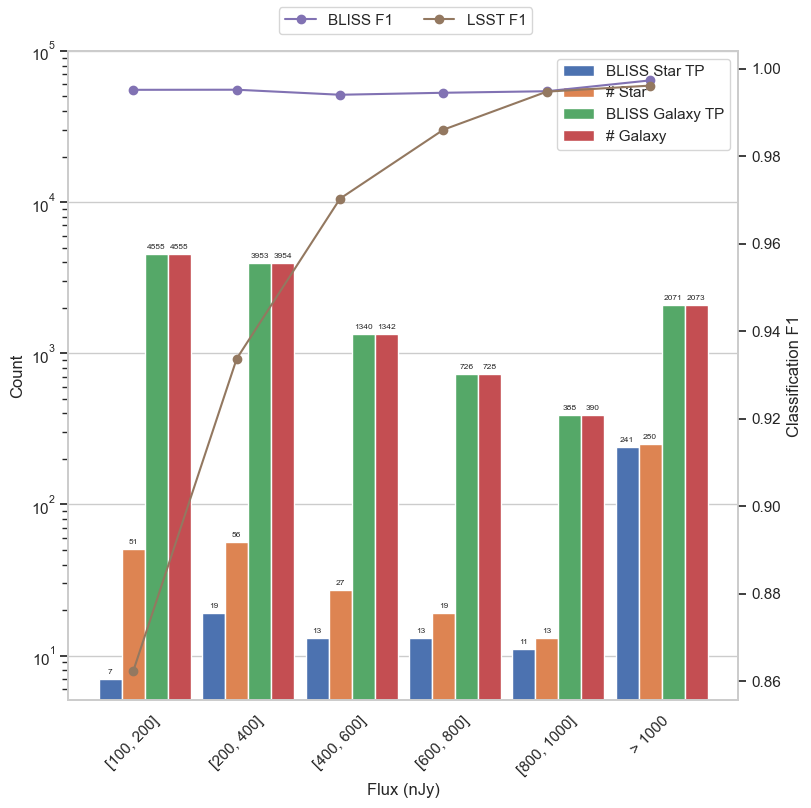

In [6]:
fig1, ax1 = plot(bliss_internal_states,
               lsst_internal_states,
               flux_bin_cutoffs=flux_bin_cutoffs)
fig1.savefig(output_dir / "classification_acc.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig1.show()

In [15]:
def separate_plot(bliss_internal_states,
         lsst_internal_states,
         flux_bin_cutoffs):
    xlabels = (
        ["[100, " + str(flux_bin_cutoffs[0]) + "]"]
        + [f"[{flux_bin_cutoffs[i]}, {flux_bin_cutoffs[i + 1]}]" for i in range(len(flux_bin_cutoffs) - 1)]
        + ["> " + str(flux_bin_cutoffs[-1])]
    )

    bar_plot_data = {
        "BLISS Star TP": bliss_internal_states["star_tp"],
        "# Star": bliss_internal_states["n_matches"] - bliss_internal_states["gal_tp"] - bliss_internal_states["star_fp"],
        "BLISS Galaxy TP": bliss_internal_states["gal_tp"],
        "# Galaxy": bliss_internal_states["n_matches"] - bliss_internal_states["star_tp"] - bliss_internal_states["gal_fp"],
    }

    sns.set_theme(style="whitegrid")
    fig1, ax1 = plt.subplots(
        1, 1, figsize=NoteBookVariables.figsize, layout="constrained"
    )
    color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    x = np.arange(len(xlabels)) * 45
    width = 10
    multiplier = 0

    for i, (data_name, data) in enumerate(bar_plot_data.items()):
        offset = width * multiplier
        rects = ax1.bar(x + offset, data, width, color=color_list[i], label=data_name)
        ax1.bar_label(rects, padding=3, fontsize=9)
        multiplier += 1

    ax1.set_ylabel("Count")
    ax1.set_xlabel("Flux (nJy)")
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(xlabels, rotation=45)
    ax1.set_yscale("log")
    ax1.set_ylim(top=1e5)
    ax1.grid(visible=False, axis="x")
    ax1.legend(loc="upper right")

    def get_f1(internal_states, galaxy: bool):
        if galaxy:
            recall = internal_states["gal_tp"] / (internal_states["gal_tp"] + internal_states["star_fp"])
            precision = internal_states["gal_tp"] / (internal_states["gal_tp"] + internal_states["gal_fp"])
        else:
            recall = internal_states["star_tp"] / (internal_states["star_tp"] + internal_states["gal_fp"])
            precision = internal_states["star_tp"] / (internal_states["star_tp"] + internal_states["star_fp"])
        f1 = 2 * precision * recall / (precision + recall)
        return f1
    
    fig2, ax2 = plt.subplots(
        1, 1, figsize=NoteBookVariables.figsize, layout="constrained"
    )
    
    ax2.plot(
        x + width,
        get_f1(bliss_internal_states, galaxy=True),
        "-o",
        color=color_list[0],
        label=f"BLISS galaxy F1",
    )
    ax2.plot(
        x + width,
        get_f1(lsst_internal_states, galaxy=True),
        "-o",
        color=color_list[2],
        label=f"LSST galaxy F1",
    )
    
    ax2.set_ylabel("Classification F1")
    ax2.set_xlabel("Flux (nJy)")
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(xlabels, rotation=45)
    ax2.grid(visible=False, axis="x")
    ax2.legend()


    fig3, ax3 = plt.subplots(
        1, 1, figsize=NoteBookVariables.figsize, layout="constrained"
    )
    
    ax3.plot(
        x + width,
        get_f1(bliss_internal_states, galaxy=False),
        "-o",
        color=color_list[0],
        label=f"BLISS star F1",
    )
    ax3.plot(
        x + width,
        get_f1(lsst_internal_states, galaxy=False),
        "-o",
        color=color_list[2],
        label=f"LSST star F1",
    )
    
    ax3.set_ylabel("Classification F1")
    ax3.set_xlabel("Flux (nJy)")
    ax3.set_xticks(x + width)
    ax3.set_xticklabels(xlabels, rotation=45)
    ax3.grid(visible=False, axis="x")
    ax3.legend()


    return fig1, fig2, fig3

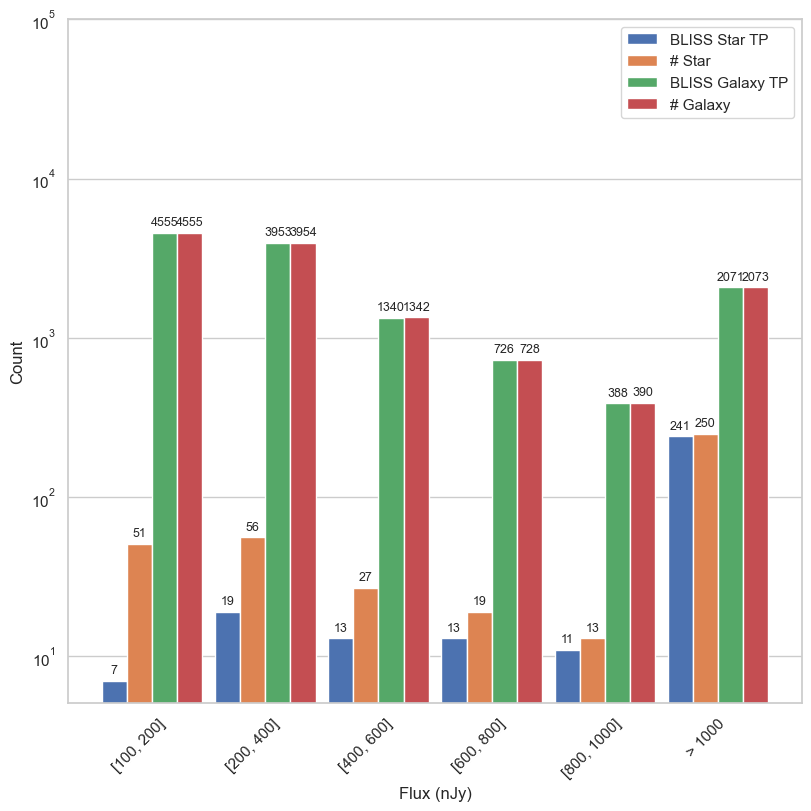

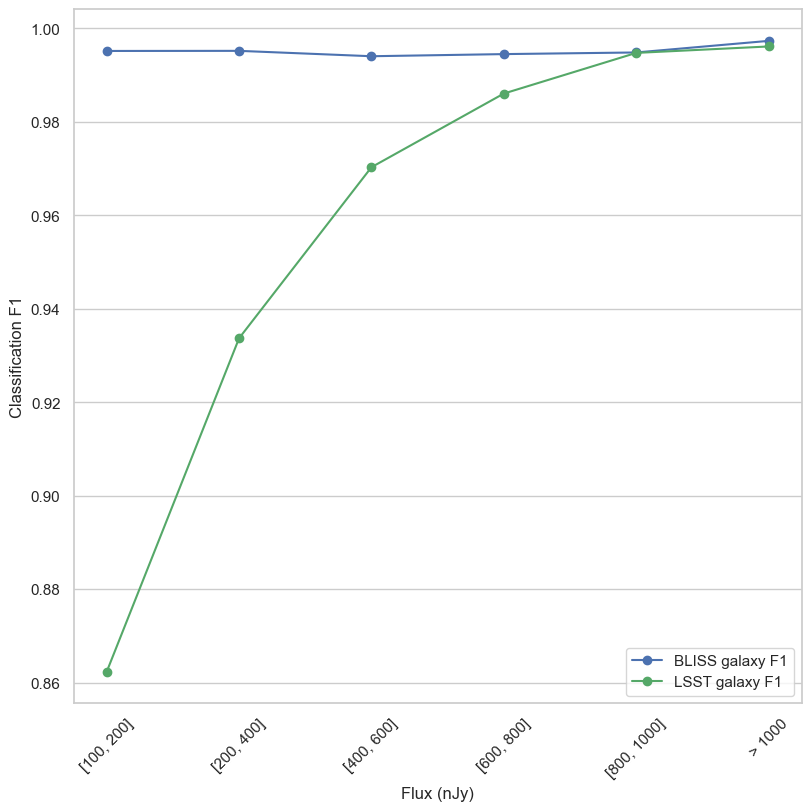

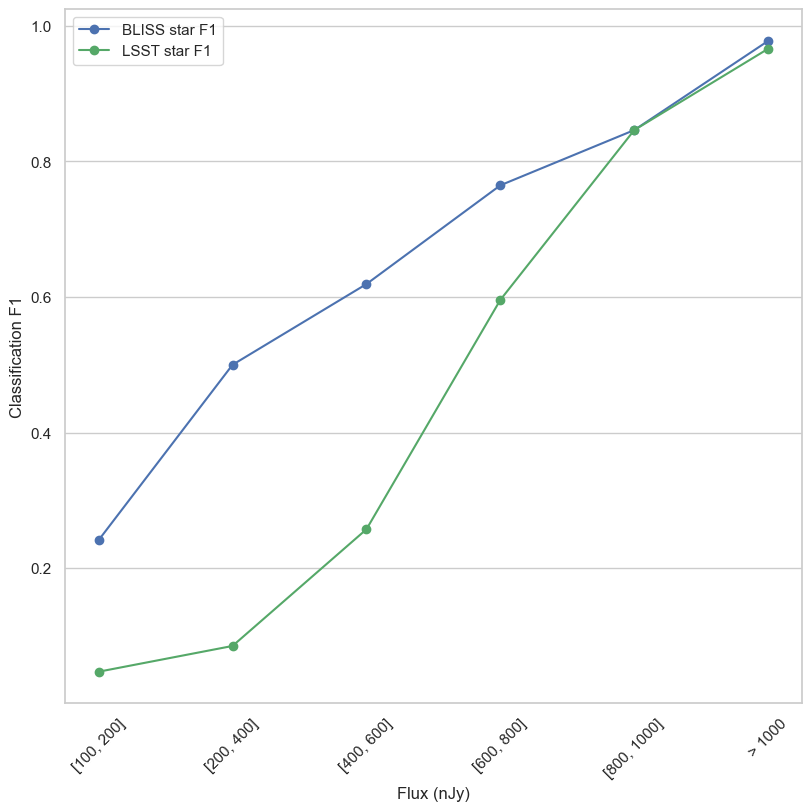

In [16]:
fig1, fig2, fig3 = separate_plot(bliss_internal_states,
                                    lsst_internal_states,
                                    flux_bin_cutoffs=flux_bin_cutoffs)
fig1.savefig(output_dir / "classification_acc_tp.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig1.show()

fig2.savefig(output_dir / "classification_galaxy_f1.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig2.show()

fig3.savefig(output_dir / "classification_star_f1.pdf", bbox_inches="tight", dpi=NoteBookVariables.dpi)
fig3.show()